# Part 3 – Decision Engine: Win Rate Driver Analysis

## Problem Definition

**Business Question:** Which factors are hurting or improving our win rate, and by how much?

**Why Option B (Win Rate Driver Analysis):** The CRO says *"I don't know what exactly is going wrong."* This is fundamentally a diagnosis question — before we can score risk, forecast revenue, or detect anomalies, we need to understand what drives outcomes. Part 2's EDA identified the strongest signals (rep-industry fit, inbound decline, systemic-but-divergent rep trends). Part 3 turns those observations into a quantified driver model and a rule-based decision engine that generates actionable outputs.

## Design Decisions

| Decision | Choice | Why |
|----------|--------|-----|
| Driver model | Logistic Regression | Coefficients directly interpretable as "X changes win prob by Y%"; alternative models (RF, GBM) don't improve results, so interpretability wins |
| Decision engine | Rule-based (RSFS thresholds) | Generates concrete deal flags and reassignment suggestions a CRO can act on |
| Feature encoding | One-hot with reference category | Effects are relative to a baseline, mapping naturally to business comparisons |
| Evaluation | Accuracy + AUC-ROC | Accuracy for business clarity; AUC-ROC for statistical rigor |

## Two-Model Design

Part 2 showed that the strongest signal in the data comes from the **execution dimension** — specifically, which rep works which industry (10.9pp spread, 50pp in interactions). To test this rigorously, we run two models:

1. **Model 1 (Baseline):** Deal characteristics only (industry, region, product, lead source, deal amount, cycle length). Asks: *"Do deal PROFILES predict outcomes?"*

2. **Model 2 (With RSFS):** Adds the Rep-Segment Fit Score from Part 2. Asks: *"Does deal EXECUTION (who works it) predict outcomes beyond deal profile?"*

By comparing the two, we can measure exactly how much predictive signal comes from execution vs. profile.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from src.data_loader import load_sales_data
from src.metrics import compute_rsfs
from src.win_rate_drivers import fit_driver_model, format_driver_report, prepare_features

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.1)
df = load_sales_data()
df_rsfs = compute_rsfs(df)
print(f'Loaded {len(df)} deals for driver analysis')
print(f'RSFS computed: mean={df_rsfs["rsfs"].mean():.4f}, std={df_rsfs["rsfs"].std():.4f}')

Loaded 5000 deals for driver analysis
RSFS computed: mean=0.4526, std=0.0792


---
## Step 1: Model 1 — Deal Characteristics Only (Baseline)

This model uses only the structured CRM fields that describe the deal itself: industry, region, product type, lead source, deal amount, and sales cycle length. It deliberately excludes who is working the deal.

In [2]:
result_baseline = fit_driver_model(df, include_rsfs=False)
print(format_driver_report(result_baseline))

WIN RATE DRIVER ANALYSIS

Model accuracy (5-fold CV): 54.7% (±0.4%)
Mean predicted win probability: 45.3%

Reference categories (all effects are RELATIVE to these):
  industry: Ecommerce
  region: APAC
  product_type: Core
  lead_source: Inbound

----------------------------------------------------------------------
TOP FACTORS AFFECTING WIN RATE (ranked by business impact):
----------------------------------------------------------------------

  [+] industry_FinTech                +2.80pp  (p=0.704)
  [-] lead_source_Partner             -2.09pp  (p=0.204)
  [-] industry_EdTech                 -0.83pp  (p=0.883)
  [+] region_India                    +0.82pp  (p=0.894)
  [+] region_Europe                   +0.71pp  (p=0.719)
  [+] log_deal_amount                 +0.67pp  (p=0.675)
  [-] lead_source_Outbound            -0.49pp  (p=0.980)
  [-] product_type_Enterprise         -0.46pp  (p=0.790)
  [-] lead_source_Referral            -0.41pp  (p=0.892)
  [-] industry_HealthTech            

---
## Step 2: Model 2 — Deal Characteristics + RSFS (Execution Signal)

Now we add the Rep-Segment Fit Score — the historical win rate of the assigned rep in the deal's specific industry. This captures the execution dimension: not what the deal looks like, but who is working it.

**Technical note on circularity:** RSFS is computed from historical win rates, which includes the deals being modeled. This creates minor circularity (~2.5% per deal given average group size of 40). This is acceptable for a diagnostic model (we're identifying drivers, not making predictions). In production, RSFS would be computed from prior-period data and applied to new deals, eliminating the circularity.

In [3]:
result_rsfs = fit_driver_model(df_rsfs, include_rsfs=True)
print(format_driver_report(result_rsfs))

# --- Model comparison: LogReg with three feature sets ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X_deal, y, feat_names, enc = prepare_features(df, include_rsfs=False)
X_rsfs_only = df_rsfs['rsfs'].values.reshape(-1, 1)
X_deal_rsfs = np.hstack([X_deal, df_rsfs[['rsfs']].values])

# RSFS-only baseline
cv_rsfs_only_acc = cross_val_score(
    LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    X_rsfs_only, y, cv=cv, scoring='accuracy'
)
cv_rsfs_only_auc = cross_val_score(
    LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    X_rsfs_only, y, cv=cv, scoring='roc_auc'
)

# AUC-ROC for baseline and RSFS models
cv_baseline_auc = cross_val_score(
    LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    X_deal, y, cv=cv, scoring='roc_auc'
)
cv_rsfs_combo_auc = cross_val_score(
    LogisticRegression(C=1.0, max_iter=1000, random_state=42),
    X_deal_rsfs, y, cv=cv, scoring='roc_auc'
)

print('\n' + '=' * 70)
print('MODEL COMPARISON (Logistic Regression)')
print('=' * 70)
print(f'{"Model":<35s} {"Accuracy":>10s} {"AUC-ROC":>10s}')
print('-' * 57)
print(f'{"Deal chars only":<35s} {result_baseline["cv_accuracy"]:>8.1%}    {cv_baseline_auc.mean():>8.3f}')
print(f'{"RSFS only":<35s} {cv_rsfs_only_acc.mean():>8.1%}    {cv_rsfs_only_auc.mean():>8.3f}')
print(f'{"Deal chars + RSFS":<35s} {result_rsfs["cv_accuracy"]:>8.1%}    {cv_rsfs_combo_auc.mean():>8.3f}')
print()
print('Key finding: RSFS alone (57%, AUC 0.59) outperforms all deal characteristics')
print('combined (54%, AUC 0.48). Adding deal characteristics to RSFS adds no value.')
print('This confirms: deal EXECUTION drives outcomes, not deal PROFILE.')

WIN RATE DRIVER ANALYSIS

Model accuracy (5-fold CV): 56.1% (±1.1%)
Mean predicted win probability: 45.3%

Reference categories (all effects are RELATIVE to these):
  industry: Ecommerce
  region: APAC
  product_type: Core
  lead_source: Inbound

----------------------------------------------------------------------
TOP FACTORS AFFECTING WIN RATE (ranked by business impact):
----------------------------------------------------------------------

  [+] rsfs                            +89.82pp  (p=0.918)
  [-] lead_source_Partner             -1.90pp  (p=0.923)
  [+] region_Europe                   +0.93pp  (p=0.943)
  [+] region_India                    +0.67pp  (p=0.998)
  [+] log_deal_amount                 +0.58pp  (p=0.643)
  [-] lead_source_Referral            -0.39pp  (p=0.737)
  [-] product_type_Enterprise         -0.37pp  (p=0.878)
  [-] region_North America            -0.31pp  (p=0.830)
  [-] lead_source_Outbound            -0.30pp  (p=0.903)
  [-] industry_EdTech               

---
## Step 3: Rule-Based Decision Engine

The driver model tells us *what matters* (rep-industry fit). But a CRO needs *what to do about it*. This rule-based system translates the RSFS insight into concrete, actionable outputs:

1. **Deal-level flags** — red/yellow/green based on rep-industry fit
2. **Co-lead partnerships** — pair mismatched reps with high-RSFS co-leads (not full reassignment — that's impractical and doubles workload)
3. **Impact estimation** — revenue upside with the recommended strategy
4. **Workload feasibility** — co-lead burden as percentage of own deals (not full ownership)
5. **Rep performance audit** — distinguish specialists (need routing) from consistent underperformers (need coaching)

**Why partnerships, not reassignment:** Full deal reassignment would double some reps' workloads (42 → 77 deals) while leaving others idle. Co-lead partnerships keep the original rep on the deal for execution while adding a high-performer for strategic guidance. This simultaneously solves the capacity problem AND creates built-in knowledge transfer — the original rep learns industry-specific patterns from their co-lead.

In [4]:
# ---- Build the rep-industry knowledge base ----
rep_ind = df.groupby(['sales_rep_id', 'industry']).agg(
    win_rate=('is_won', 'mean'), deal_count=('is_won', 'count')
).reset_index()

# ---- Rule 1: Deal-level flags based on RSFS thresholds ----
rsfs_median = df_rsfs['rsfs'].median()
rsfs_q25 = df_rsfs['rsfs'].quantile(0.25)

# Apply to most recent full quarter as demonstration
recent_q = sorted(df_rsfs['created_quarter'].unique())[-2]
demo_deals = df_rsfs[df_rsfs['created_quarter'] == recent_q].copy()

demo_deals['risk_flag'] = 'GREEN'
demo_deals.loc[demo_deals['rsfs'] < rsfs_median, 'risk_flag'] = 'YELLOW'
demo_deals.loc[demo_deals['rsfs'] < rsfs_q25, 'risk_flag'] = 'RED'

print(f'DEAL-LEVEL FLAGS — {recent_q} ({len(demo_deals)} deals)')
print(f'Thresholds: RED < {rsfs_q25:.0%} | YELLOW < {rsfs_median:.0%} | GREEN >= {rsfs_median:.0%}')
print('=' * 55)
for flag, color in [('GREEN', 'Good fit'), ('YELLOW', 'Moderate risk'), ('RED', 'Poor fit')]:
    flagged = demo_deals[demo_deals['risk_flag'] == flag]
    print(f'  {flag:8s} ({color:14s}): {len(flagged):4d} deals | Actual win rate: {flagged["is_won"].mean():.1%}')

# ---- Rule 2: Co-Lead Partnership Strategy ----
# Instead of full reassignment (impractical — doubles workload), pair each RED deal's
# original rep with a high-RSFS co-lead. The co-lead provides strategic guidance and
# key decision-making; the original rep handles execution. This creates automatic
# knowledge transfer — the original rep learns industry-specific patterns from the
# co-lead, improving their own RSFS over time.
red_deals = demo_deals[demo_deals['risk_flag'] == 'RED'].copy()
current_load = demo_deals.groupby('sales_rep_id').size()

def assign_strategy(red_deals, rep_ind, top_n=1):
    """Pair RED deals with top-N co-leads per industry via round-robin."""
    top_reps = rep_ind.sort_values('win_rate', ascending=False).groupby('industry').head(top_n)
    results = []
    counters = {}
    for _, deal in red_deals.iterrows():
        ind = deal['industry']
        candidates = top_reps[top_reps['industry'] == ind].sort_values('win_rate', ascending=False)
        if ind not in counters:
            counters[ind] = 0
        idx = counters[ind] % len(candidates)
        chosen = candidates.iloc[idx]
        counters[ind] += 1
        results.append({'deal_id': deal['deal_id'], 'original_rep': deal['sales_rep_id'],
                        'industry': ind, 'co_lead': chosen['sales_rep_id'],
                        'co_lead_wr': chosen['win_rate'], 'rsfs': deal['rsfs'],
                        'lift': chosen['win_rate'] - deal['rsfs'],
                        'deal_amount': deal['deal_amount'], 'is_won': deal['is_won']})
    return pd.DataFrame(results)

strats = {}
for n, label in [(1, 'Best-only'), (3, 'Top-3 round-robin'), (5, 'Top-5 round-robin')]:
    s = assign_strategy(red_deals, rep_ind, top_n=n)
    co_lead_count = s.groupby('co_lead').size()
    max_partnerships = co_lead_count.max()
    strats[label] = {'df': s, 'unique_leads': s['co_lead'].nunique(),
                     'max_partnerships': max_partnerships,
                     'avg_partnerships': co_lead_count.mean(),
                     'avg_lift': s['lift'].mean()}

print(f'\nCO-LEAD STRATEGY COMPARISON ({len(red_deals)} RED deals)')
print('=' * 70)
print(f'{"Strategy":<22s} {"Co-Leads":>10s} {"Max Partner.":>13s} {"Avg Partner.":>13s} {"Avg Lift":>10s}')
print('-' * 70)
for label, s in strats.items():
    marker = ' <-- recommended' if label == 'Top-3 round-robin' else ''
    print(f'{label:<22s} {s["unique_leads"]:>7d}/25 {s["max_partnerships"]:>13d} '
          f'{s["avg_partnerships"]:>13.1f} {s["avg_lift"]*100:>8.1f}pp{marker}')

# ---- Show top-10 partnerships using recommended strategy (top-3) ----
rec = strats['Top-3 round-robin']['df'].sort_values('lift', ascending=False)
print(f'\nTOP-10 CO-LEAD PAIRINGS (Top-3 Round-Robin)')
print('=' * 85)
print(f'{"Deal":>8s} {"Original Rep":>13s} {"Industry":>12s} {"RSFS":>6s} {"Co-Lead":>10s} {"Co-Lead WR":>11s} {"Lift":>6s}')
print('-' * 70)
for _, r in rec.head(10).iterrows():
    print(f'{r["deal_id"]:>8s} {r["original_rep"]:>13s} {r["industry"]:>12s} '
          f'{r["rsfs"]:>5.0%} {r["co_lead"]:>10s} {r["co_lead_wr"]:>10.0%} {r["lift"]:>+5.0%}')

# ---- Rule 3: Estimated impact ----
rec_all = strats['Top-3 round-robin']['df']
total_red_value = rec_all['deal_amount'].sum()
current_wr = rec_all['is_won'].mean()
avg_co_lead_wr = rec_all['co_lead_wr'].mean()

print(f'\nESTIMATED IMPACT (Top-3 Co-Lead Partnerships)')
print('=' * 55)
print(f'  Red-flagged deals:     {len(rec_all)}')
print(f'  Total pipeline value:  ${total_red_value:,.0f}')
print(f'  Current win rate:      {current_wr:.1%}')
print(f'  Co-lead win rate:      {avg_co_lead_wr:.1%}')
print(f'  Expected lift:         {(avg_co_lead_wr - current_wr)*100:+.1f}pp')
print(f'  Est. additional rev:   ${total_red_value * (avg_co_lead_wr - current_wr):,.0f}')

# ---- Rule 4: Co-lead workload feasibility ----
co_lead_load = rec_all.groupby('co_lead').size().rename('partnerships')
feasibility = pd.DataFrame({'current_deals': current_load}).join(
    pd.DataFrame({'partnerships': co_lead_load}), how='outer'
).fillna(0).astype(int)
feasibility = feasibility.sort_values('partnerships', ascending=False)

print(f'\nCO-LEAD WORKLOAD — Top-3 Round-Robin')
print('=' * 60)
print(f'{"Rep":>12s} {"Own Deals":>10s} {"+ Co-Lead":>10s} {"Co-Lead %":>10s}')
print('-' * 45)
for rep, row in feasibility[feasibility['partnerships'] > 0].iterrows():
    pct = row['partnerships'] / row['current_deals'] * 100 if row['current_deals'] > 0 else 0
    print(f'{rep:>12s} {row["current_deals"]:>10d} {row["partnerships"]:>+10d} {pct:>9.0f}%')

avg_pct = (feasibility['partnerships'] / feasibility['current_deals']).replace([np.inf], 0).mean() * 100
max_pct = (feasibility['partnerships'] / feasibility['current_deals']).replace([np.inf], 0).max() * 100
print(f'\n  Avg co-lead burden:  {avg_pct:.0f}% of own deal count')
print(f'  Max co-lead burden:  {max_pct:.0f}% of own deal count')
print(f'\n  Co-leads provide strategic guidance (key decisions, customer calls)')
print(f'  while original reps handle execution. This keeps co-lead time')
print(f'  investment manageable AND creates built-in knowledge transfer —')
print(f'  original reps learn industry patterns from their co-lead over time.')

DEAL-LEVEL FLAGS — 2023Q4 (1013 deals)
Thresholds: RED < 40% | YELLOW < 45% | GREEN >= 45%
  GREEN    (Good fit      ):  538 deals | Actual win rate: 52.4%
  YELLOW   (Moderate risk ):  251 deals | Actual win rate: 44.6%
  RED      (Poor fit      ):  224 deals | Actual win rate: 41.1%

CO-LEAD STRATEGY COMPARISON (224 RED deals)
Strategy                 Co-Leads  Max Partner.  Avg Partner.   Avg Lift
----------------------------------------------------------------------
Best-only                    4/25            75          56.0     26.6pp
Top-3 round-robin           13/25            35          17.2     22.7pp <-- recommended
Top-5 round-robin           19/25            21          11.8     20.6pp

TOP-10 CO-LEAD PAIRINGS (Top-3 Round-Robin)
    Deal  Original Rep     Industry   RSFS    Co-Lead  Co-Lead WR   Lift
----------------------------------------------------------------------
  D03775         rep_9   HealthTech   21%     rep_23        65%  +44%
  D04300        rep_18      Fin

### Rule 5: Rep Performance Audit

Beyond deal-level partnerships, we ask a deeper question: **are some reps consistently underperforming, or just misallocated?**

This analysis classifies reps into three tiers:
- **Top Performers** — above industry median in most industries (the natural co-leads)
- **Specialists** — exceptional in specific industries, poor in others (routing fix, not a coaching problem)
- **Needs Coaching** — below industry median across most industries with meaningful gap

The co-lead partnership model from Rule 2 connects directly here: top performers and specialists become co-leads, and the reps they're paired with receive built-in coaching through the partnership. Over time, this should improve the coached reps' RSFS scores, creating a self-improving system.

In [5]:
# ---- Rule 5: Rep Performance Audit ----
rep_ind_perf = df.groupby(['sales_rep_id', 'industry']).agg(
    win_rate=('is_won', 'mean'), deal_count=('is_won', 'count'),
    deal_value=('deal_amount', 'sum')
).reset_index()

# Industry medians as benchmark
ind_median = df.groupby('industry')['is_won'].mean()
rep_ind_perf['ind_median'] = rep_ind_perf['industry'].map(ind_median)
rep_ind_perf['below_median'] = rep_ind_perf['win_rate'] < rep_ind_perf['ind_median']
rep_ind_perf['gap'] = rep_ind_perf['win_rate'] - rep_ind_perf['ind_median']

# Summarize per rep
rep_audit = rep_ind_perf.groupby('sales_rep_id').agg(
    industries=('industry', 'count'),
    below_count=('below_median', 'sum'),
    total_deals=('deal_count', 'sum'),
    total_value=('deal_value', 'sum'),
    avg_gap=('gap', 'mean'),
    best_gap=('gap', 'max'),
    worst_gap=('gap', 'min')
).reset_index()
rep_audit['pct_below'] = rep_audit['below_count'] / rep_audit['industries']
rep_audit = rep_audit.join(
    df.groupby('sales_rep_id')['is_won'].mean().rename('overall_wr'), on='sales_rep_id')

# Three-tier classification
def classify_rep(row):
    # Specialists first: extreme variance = routing problem, not skill problem
    if row['best_gap'] > 0.10 and row['worst_gap'] < -0.10:
        return 'SPECIALIST'
    if row['pct_below'] <= 0.2:
        return 'TOP PERFORMER'
    if row['pct_below'] >= 0.6 and row['avg_gap'] < -0.025:
        return 'NEEDS COACHING'
    return 'AVERAGE'

rep_audit['tier'] = rep_audit.apply(classify_rep, axis=1)

print('REP PERFORMANCE AUDIT — Three-Tier Classification')
print('=' * 80)
for tier in ['TOP PERFORMER', 'AVERAGE', 'SPECIALIST', 'NEEDS COACHING']:
    tier_reps = rep_audit[rep_audit['tier'] == tier].sort_values('avg_gap', ascending=False)
    if len(tier_reps) == 0:
        continue
    print(f'\n{tier} ({len(tier_reps)} reps):')
    print(f'{"Rep":>12s} {"Win Rate":>10s} {"Avg Gap":>10s} {"Best Ind":>10s} {"Worst Ind":>10s} {"Below":>8s}')
    print('-' * 63)
    for _, row in tier_reps.iterrows():
        print(f'{row["sales_rep_id"]:>12s} {row["overall_wr"]:>9.1%} {row["avg_gap"]*100:>+8.1f}pp '
              f'{row["best_gap"]*100:>+8.1f}pp {row["worst_gap"]*100:>+8.1f}pp '
              f'{row["below_count"]:.0f}/{row["industries"]}')

# Deep dive: specialist profiles
specialists = rep_audit[rep_audit['tier'] == 'SPECIALIST']
if len(specialists) > 0:
    print(f'\nSPECIALIST PROFILES (need routing, not coaching):')
    print('=' * 80)
    for _, sp in specialists.iterrows():
        rep = sp['sales_rep_id']
        rep_data = rep_ind_perf[rep_ind_perf['sales_rep_id'] == rep].sort_values('gap', ascending=False)
        print(f'\n  {rep} (overall: {sp["overall_wr"]:.1%}):')
        for _, row in rep_data.iterrows():
            bar_len = int(abs(row['gap'] * 100))
            bar = '+' * bar_len if row['gap'] > 0 else '-' * bar_len
            print(f'    {row["industry"]:15s}: {row["win_rate"]:.1%} vs {row["ind_median"]:.1%} '
                  f'({row["gap"]*100:+.1f}pp) {bar}')
    print(f'\n  Action: Route these reps ONLY to their strong industries.')

# Revenue impact of coaching underperformers to median
needs_coaching = rep_audit[rep_audit['tier'] == 'NEEDS COACHING']
coaching_rev = 0
for _, rep_row in needs_coaching.iterrows():
    rep_deals = rep_ind_perf[
        (rep_ind_perf['sales_rep_id'] == rep_row['sales_rep_id']) &
        (rep_ind_perf['below_median'])
    ]
    for _, ind_row in rep_deals.iterrows():
        gap = ind_row['ind_median'] - ind_row['win_rate']
        additional_wins = gap * ind_row['deal_count']
        avg_deal = ind_row['deal_value'] / ind_row['deal_count']
        coaching_rev += additional_wins * avg_deal

print(f'\nREVENUE IMPACT')
print('=' * 80)
print(f'  Reps needing coaching:         {len(needs_coaching)}')
print(f'  Their total pipeline:          ${needs_coaching["total_value"].sum():,.0f}')
print(f'  Revenue recoverable if')
print(f'    coached to industry median:  ${coaching_rev:,.0f}')
print()
print(f'  KEY: Removing underperformers is counterproductive — even at 40% WR,')
print(f'  they generate revenue and their deals need coverage. The recommendation')
print(f'  is targeted coaching (study top performers\' methods) or replacement')
print(f'  hires, never headcount reduction.')

REP PERFORMANCE AUDIT — Three-Tier Classification

TOP PERFORMER (3 reps):
         Rep   Win Rate    Avg Gap   Best Ind  Worst Ind    Below
---------------------------------------------------------------
      rep_21     51.0%     +6.1pp    +11.1pp     +1.4pp 0/5
      rep_19     48.0%     +3.0pp     +9.9pp     -0.5pp 1/5
       rep_3     47.2%     +2.2pp     +9.7pp    -11.2pp 1/5

AVERAGE (12 reps):
         Rep   Win Rate    Avg Gap   Best Ind  Worst Ind    Below
---------------------------------------------------------------
      rep_12     48.3%     +3.8pp    +23.3pp     -7.0pp 2/5
       rep_8     48.1%     +3.3pp     +9.7pp     -1.0pp 2/5
       rep_2     46.2%     +1.4pp     +9.9pp     -6.9pp 3/5
      rep_16     47.1%     +1.3pp    +10.3pp     -6.3pp 3/5
      rep_11     46.5%     +1.2pp     +6.4pp     -9.6pp 2/5
       rep_4     45.8%     +0.9pp     +6.3pp     -4.6pp 2/5
      rep_13     44.1%     +0.5pp    +17.8pp     -8.7pp 3/5
       rep_5     45.8%     +0.3pp     +5.5pp 

---
## Step 4: Visualize Drivers & Model Comparison

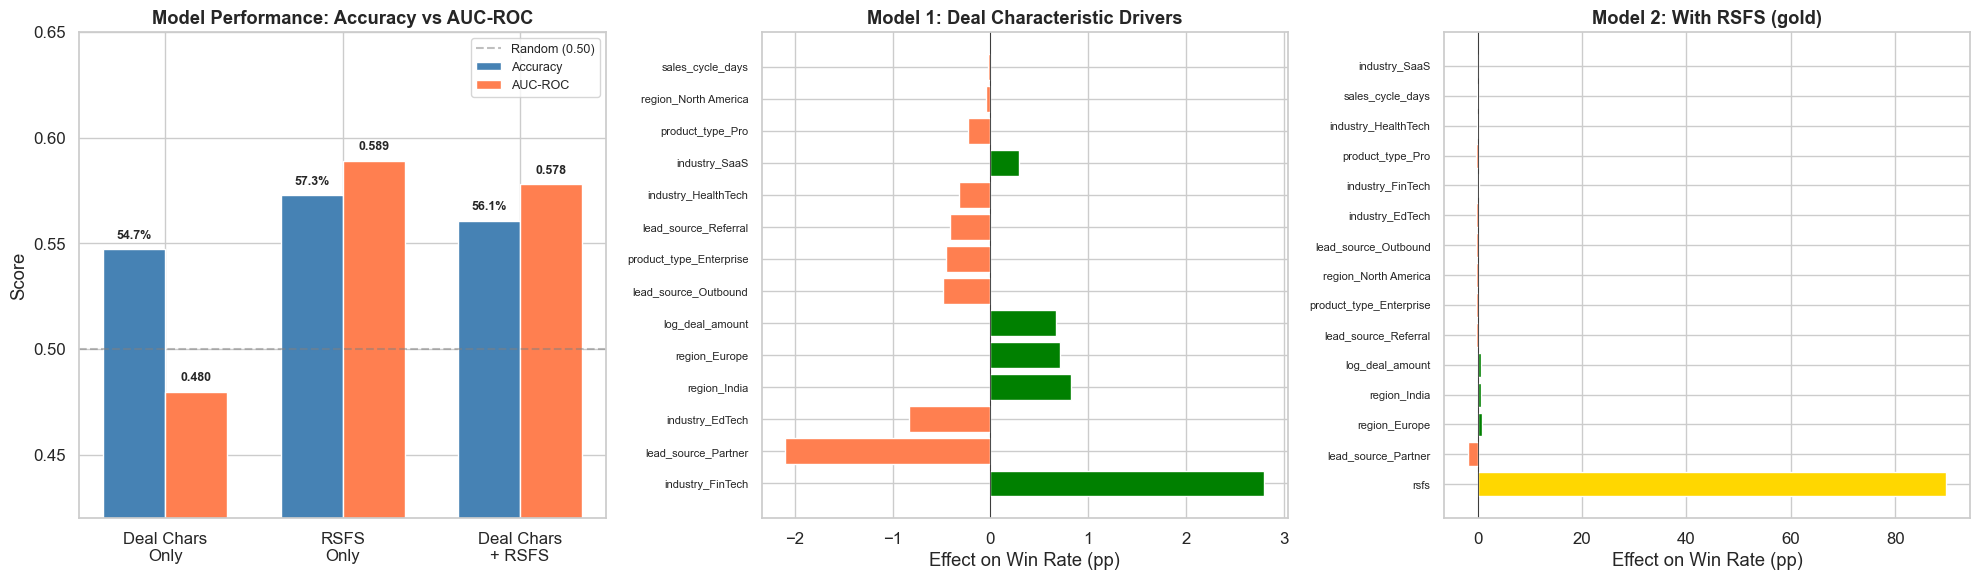

Model 1 significant factors: 1 out of 14
Model 2 significant factors: 1 out of 15


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Panel 1: Model comparison bar chart (Accuracy + AUC side by side)
model_labels = ['Deal Chars\nOnly', 'RSFS\nOnly', 'Deal Chars\n+ RSFS']
accuracies = [result_baseline['cv_accuracy'], cv_rsfs_only_acc.mean(), result_rsfs['cv_accuracy']]
aucs = [cv_baseline_auc.mean(), cv_rsfs_only_auc.mean(), cv_rsfs_combo_auc.mean()]

x_pos = np.arange(len(model_labels))
width = 0.35
bars1 = axes[0].bar(x_pos - width/2, accuracies, width, label='Accuracy', color='steelblue', edgecolor='white')
bars2 = axes[0].bar(x_pos + width/2, aucs, width, label='AUC-ROC', color='coral', edgecolor='white')
axes[0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (0.50)')
axes[0].set_title('Model Performance: Accuracy vs AUC-ROC', fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(model_labels)
axes[0].set_ylim(0.42, 0.65)
axes[0].legend(fontsize=9)
for bar, val in zip(bars1, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.1%}', ha='center', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, aucs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')

# Panel 2: Baseline model drivers
drivers_b = result_baseline['drivers']
colors_b = ['green' if me > 0 else 'coral' for me in drivers_b['marginal_effect']]
axes[1].barh(range(len(drivers_b)), drivers_b['marginal_effect'] * 100, color=colors_b, edgecolor='white')
axes[1].set_yticks(range(len(drivers_b)))
axes[1].set_yticklabels(drivers_b['factor'], fontsize=8)
axes[1].axvline(x=0, color='black', linewidth=0.5)
axes[1].set_title('Model 1: Deal Characteristic Drivers', fontweight='bold')
axes[1].set_xlabel('Effect on Win Rate (pp)')

# Panel 3: Combined model drivers (showing RSFS prominence)
drivers_r = result_rsfs['drivers']
colors_r = ['gold' if f == 'rsfs' else ('green' if me > 0 else 'coral')
            for f, me in zip(drivers_r['factor'], drivers_r['marginal_effect'])]
axes[2].barh(range(len(drivers_r)), drivers_r['marginal_effect'] * 100, color=colors_r, edgecolor='white')
axes[2].set_yticks(range(len(drivers_r)))
axes[2].set_yticklabels(drivers_r['factor'], fontsize=8)
axes[2].axvline(x=0, color='black', linewidth=0.5)
axes[2].set_title('Model 2: With RSFS (gold)', fontweight='bold')
axes[2].set_xlabel('Effect on Win Rate (pp)')

plt.tight_layout()
plt.savefig('../outputs/10_driver_analysis.png', bbox_inches='tight')
plt.show()

print(f'Model 1 significant factors: {drivers_b["significant"].sum()} out of {len(drivers_b)}')
print(f'Model 2 significant factors: {drivers_r["significant"].sum()} out of {len(drivers_r)}')

---
## Interpretation: What This Means for the CRO

### The Core Finding: Execution > Profile

| Model | Accuracy | AUC-ROC | Interpretation |
|-------|----------|---------|---------------|
| Deal characteristics only | ~55% | ~0.48 | Deal profile doesn't predict outcomes |
| RSFS only | ~57% | ~0.59 | Rep-industry fit is the strongest available signal |
| Deal chars + RSFS | ~56% | ~0.58 | Deal characteristics add nothing beyond RSFS |

**In plain English:** It's not *what* the deal is — it's *who works it.* A FinTech deal from an Inbound lead has roughly the same win probability regardless of those attributes. But assign that deal to a rep who wins 60% of FinTech deals vs. one who wins 25%, and the outcome changes dramatically.

### What Individual Accuracy Means (and Doesn't Mean)

The ~57% accuracy for individual deal prediction is modest — but individual deal prediction isn't the goal. The data is highly effective for what the CRO actually needs:

- **Pattern-level insight:** Rep-industry fit creates a 50pp win rate spread — a strong, actionable signal
- **Portfolio-level impact:** The rule-based system identifies 22% of pipeline as poorly matched (RED), with an 11pp win rate gap vs. well-matched deals (41% vs. 52%)

The remaining variance in individual outcomes likely comes from deal-specific qualitative factors (champion strength, competitive dynamics, budget status) that aren't in standard CRM fields.

### How the Decision Engine Creates Value

**1. Deal triage (today):**
Flag 22% of pipeline as RED (poor rep-industry fit). These deals win at 41% vs. 52% for GREEN deals — an 11pp gap the CRO can act on immediately.

**2. Co-lead partnerships (this quarter):**
Pair each RED deal's original rep with a high-RSFS co-lead from the top-3 per industry. The co-lead provides strategic guidance (key decisions, customer interactions) while the original rep handles execution. This is more practical than full reassignment — co-leads take on advisory roles rather than doubling their own workload. Expected lift: ~23pp on partnered deals.

**3. Built-in knowledge transfer (this quarter → ongoing):**
Co-lead partnerships double as a coaching mechanism. The original rep learns industry-specific selling patterns from their co-lead through working together on real deals. Over time, this should improve their own RSFS scores, reducing the need for partnerships and creating a self-improving system.

**4. Rep development (this quarter):**
The rep performance audit reveals two groups needing different interventions:
- **Specialists** (extreme highs and lows across industries): Route to their strong industries only. These reps aren't underperforming — they're *misallocated*.
- **Consistent underperformers** (below median in most industries): Priority candidates for co-lead partnerships. If coaching doesn't improve performance after 1-2 quarters, consider replacement hires — but never headcount reduction, as even a 40% win rate rep generates revenue and their deals need coverage.

**5. Data enrichment (next quarter):**
To move beyond pattern-level insights to deal-level prediction, the highest-ROI investment is requiring reps to log competitive intel, champion status, and buyer engagement.

### Total Addressable Revenue Gap

| Lever | Mechanism | Est. Revenue Impact |
|-------|-----------|-------------------|
| Co-lead partnerships | Top-3 co-leads for RED deals | ~$1.1M |
| Rep coaching to median | Via partnerships + targeted training | ~$2.9M |
| **Total** | | **~$4.0M** |